In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = l1_regularizer))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

C:\Users\AI-lab\anaconda3\envs\branch_opencv\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\AI-lab\github_repo\neural-network\python\ga.py:197: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\AI-lab\anaconda3\envs\branch_opencv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a

Checkpoint 100, Accuracy: 0.9506172839506173, Loss: 0.2534982010170265
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.22930609738385235
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.2016004103201407
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.18112191447505244
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.17640433488068757


In [10]:
print(history)

[{'accuracy': 0.8193146417445483, 'mean_square_error': 2.71681088683549, 'categorical_crossentropy': 0.727097413250219, 'precision': 0.7289719626168224, 'recall': 0.7289719626168224, 'f1': 0.7289719626168223, 'essential_metrics': {0: {'tp_hit': 68, 'fp_hit': 14, 'tn_hit': 19, 'fn_hit': 6}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 89, 'fn_hit': 18}, 2: {'tp_hit': 10, 'fp_hit': 15, 'tn_hit': 77, 'fn_hit': 5}}}, {'accuracy': 0.8130841121495327, 'mean_square_error': 0.4049904478051572, 'categorical_crossentropy': 0.7592470400801329, 'precision': 0.719626168224299, 'recall': 0.719626168224299, 'f1': 0.7196261682242989, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 30, 'tn_hit': 3, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 89, 'fn_hit': 18}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 12}}}, {'accuracy': 0.8442367601246106, 'mean_square_error': 0.3124447328187148, 'categorical_crossentropy': 0.5105855710038515, 'precision': 0.7663551401869159, 'recall': 0.76635514018

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8779603  0.09916931 0.02287032]
[1. 0. 0.] <-> [0.9378078  0.04577485 0.01641737]
[0. 0. 1.] <-> [0.07324214 0.00166051 0.92509735]
[1. 0. 0.] <-> [0.9056132  0.0697039  0.02468294]
[0. 0. 1.] <-> [0.07147763 0.00178443 0.92673796]
[1. 0. 0.] <-> [0.8662533  0.02049424 0.1132525 ]
[1. 0. 0.] <-> [0.9228431  0.05370389 0.02345301]
[1. 0. 0.] <-> [0.9165734  0.01356322 0.06986345]
[1. 0. 0.] <-> [0.7586223  0.01319078 0.22818685]
[1. 0. 0.] <-> [0.92178535 0.03969431 0.03852035]
[1. 0. 0.] <-> [0.91958016 0.01830193 0.06211795]
[0. 1. 0.] <-> [0.34775278 0.64328486 0.00896242]
[0. 1. 0.] <-> [0.40442172 0.5798342  0.01574402]
[1. 0. 0.] <-> [0.9363881  0.04504059 0.01857133]
[1. 0. 0.] <-> [0.85360026 0.0139835  0.13241623]
[1. 0. 0.] <-> [0.9282258  0.04509138 0.02668277]
[1. 0. 0.] <-> [0.8780597  0.01952985 0.10241046]
[0. 1. 0.] <-> [0.16111483 0.8336325  0.00525263]
[1. 0. 0.] <-> [0.94172347 0.02928947 0.02898716]
[1. 0. 0.] <-> [0.9367266  0.03421215 0.0290612 ]


In [14]:
# Testing Performance

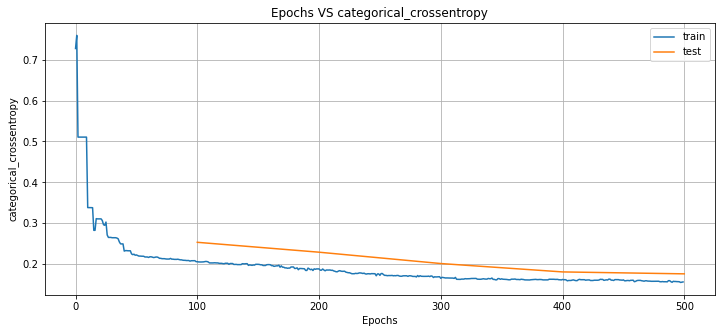

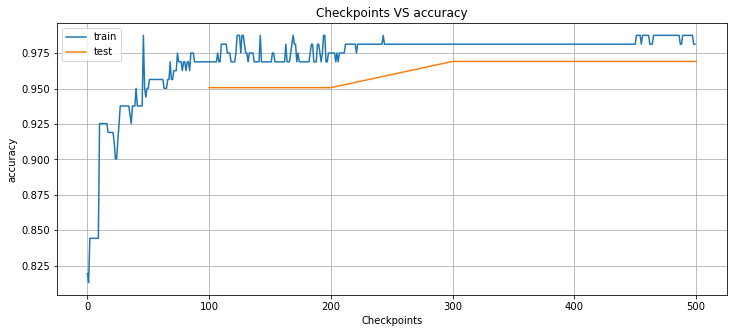

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9506172839506173, 'mean_square_error': 0.12662503203683043, 'categorical_crossentropy': 0.2534982010170265, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 5}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.11082543673938783, 'categorical_crossentropy': 0.22930609738385235, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 5}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.09265337559682703, 'categorical_crossentropy': 0.2016004103201407, 'precisi

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.38123617 -2.1974695   0.00698496  0.17092565  0.76363695]
 bias: -1.8605040311813354

Neuron 1: weights:
[-0.41001743  0.56505364 -0.43219537 -2.3912652  -0.965768  ]
 bias: 0.7018240094184875

Neuron 2: weights:
[ 0.54370326 -1.3523257  -1.2079821  -0.01182484  0.453478  ]
 bias: 1.16009521484375

Neuron 3: weights:
[-0.248212    1.2224456   0.01083762  0.14141834  0.00281243]
 bias: -0.09819155186414719

$
Layer 2
Neuron 0: weights:
[-2.522495    0.03875685  2.6638541  -1.5918105 ]
 bias: 1.263537049293518

Neuron 1: weights:
[-1.1233275e+00  1.3808516e-03 -2.9917021e+00  8.8699108e-01]
 bias: 1.2838340997695923

Neuron 2: weights:
[ 2.241177  -2.7940347  1.5869377 -0.9339697]
 bias: 0.001090648933313787

$

